## Introduction

This tutorial is a step by step guide to model various interactions between multiple biomolecular models. Broadly, there are three major kinds of interaction and interconnections between different models that this toolbox helps in modeling. The toolbox works with models written in Systems Biology Markup Language (SBML), effectively taking multiple SBML models as input models and giving a new model written in SBML which models the interaction as desired by the user between the input models. 

### Interaction Modeling 
There are different kinds of interactions that commonly occur which can be modeled using this toolbox:-

1. **Shared resources** -  A user defined list of species for a System which all the Subsystems that are placed inside the System share among them as common resources. So, the multiple Subsystems with SBML models in a System will share these species, rather than having different species for each (as would be the case if they were isolated or in different Systems). 

2. **Combine subsystems** - A list of Subsystems may be combined together as desired by the user. A combination of multiple Subsystems gives a new Subsystem with all components of the different input Subsystems merged together. Also, if desired, all species with the same name that occur across different subsystems may be combined in the combined model. When calling the member function, the argument for `combineNames` is set as `True` if it is desired to combine all species which have the same `name` attribute. A `False` for the argument would keep all the Species separate even if they have the same name (however, if they are in the same System, the shared species (as described above in 1) will still be shared). In this case, all components of the Subsystems will be merged together. The `combineNames` argument is optional and the default value is set as `True`. There are two modes in which Subsystems may be combined - 

    1. **Combine by volume** - When combining multiple Subsystems together experimentally by mixing different volumes of each together, this method may be used. The System model (i.e. the combined model of all Subsystems given) has a compartment volume equal to the sum of volumes of the Subsystems' compartments. The initial amount of all Species that have the same `name` and are being combined together (i.e. the `combineNames` argument is set as `True`) is calculated as follows: $$[A_{total}] = \frac{\sum_{i=1}^{N}[A_i] \times V_i}{\sum_{i=1}^{N} V_i}$$ where N is the total number of Subsystems, A is any species which is present in i = 1,2,..,N Subsystems with V denoting the corresponding volumes. 
    
    The default `self.combineSubsystems(ListOfSubsystems, combineNames = 'True', mode = 'virtual')` call performs combine in  virtual mode as described below. 
    2. **Combine virtually** - In this mode, the combined model of all Subsystems given has a compartment volume equal to the compartment volume of the first Subsystem in the list of Subsystems given in the argument of the function call. Similarly, a species which is combined when `combineNames` is set as `True`, takes the initial amount from the first Subsystem in the list of subsystems in which it is listed. 
    
3. **Species Identification** - For some applications, it might be desired to combine species with different names. The `connectSubsystems` method allows to model such an interaction. A connection map (Python dictionary) can be defined which describes the species names that get combined with some other species name. The amount for the new connected species, may either be set as sum of the two species being combined (by setting the optional argument `amount_mode = 'additive'`) OR the species amount may be given specifically as an argument, in which case, the optional arguments are `amount_mode = 'constant'`, and `connected_species_amount = amount`). Usage - connectSubsystems(self, ListOfSubsystems, connectionMap, mode = 'virtual', combineNames = False, amount_mode = 'additive', connected_species_amount = 0):

   
   
### Example

To demonstrate al of the functionalities described above, we consider three models written in SBML given to us. Refer to `tutorial_modeling.ipynb` for a tutorial on creating new SBML models from scratch using simple commands. 

For this tutorial, we have two double phosphorylation subsystems and an incoherent feedforward loop subsystem given as SBML files. We intend to have all of the three subsystems inside a synthetic cell and use them as examples to demonstrate the different interconnections and interaction modeling.

Import the required libraries from the modules class. 

In [2]:
from libsbml import *
from modules.System import *
from modules.Subsystem import *
from modules.SimpleModel import *
from modules.SimpleReaction import *

Create a system. Example - A cell system which acts as a container for 
all of the different subsystems. Here, cell is an object of the System class. 

Specify the list of resources which are shared for this System. Usage - `self.ListOfSharedResources = ['X','Y']`. The ListOfSharedResources is maintained for objects of System class.

The three Subsystems are created inside the System using `self.createSubsystem(filename, component_suffix = '')` of the System class, which takes a SBML file as its first argument and an optional string argument which is used to suffix all elements of the Subsystem. For example, in the DP1 call, the string 'DP1' will be suffixed to identifiers of all Species, Reactions, Parameters etc. 

The System class call of `self.ListOfSubsystem` prints the Subsystem objects in the System.

In [4]:
cell = System('cell')
cell.ListOfSharedResources = ['inP','X:P']
DP1 = cell.createSubsystem('models/DP.xml','DP1')
DP2 = cell.createSubsystem('models/DP.xml','DP2')
IFFL = cell.createSubsystem('models/IFFL.xml','IFFL')
print(cell.ListOfInternalSubsystems)

[<modules.Subsystem.Subsystem object at 0x0000021CE5934940>, <modules.Subsystem.Subsystem object at 0x0000021CE5934FD0>, <modules.Subsystem.Subsystem object at 0x0000021CE5934B00>]


### Shared Cellular Resources
Set the list of shared resources to the cell using its member function `self.setSharedResources()`. Modeling of bullet point number 1 is done using this member function. 
Usage - `self.setSharedResources()`, sets the `self.ListOfSharedResources` to the Subsystems that are currently present inside the System and returns a new Subsystem with the combined model of all the Subsystems together sharing resources.
Using `writeSBML`, this shared Subsystem model is written to an SBML file. On running the following code, the file should be generated in the models folder within the current directory. The shared Subsystem model can be simulated using bioscrape. The result is plotted on running the following. You may change the species you wish to plot in the `plotSbmlWithBioscrape(...)` command below by changing the `ListOfSpeciesToPlot` argument.

C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\utilityFunctions.py:45: UserWarning: Warning: SBML model contains reversible reaction!
Please check rate expressions and ensure they are non-negative before doing stochastic simulations. This warning will always appear if you are using SBML 1 or 2
  m = bioscrape.types.read_model_from_sbml(filename)
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\SimpleModel.py:417: UserWarning: Multiple species with name X:P:P found. Returning a list
  warnings.warn('Multiple species with name ' + name + ' found. Returning a list')


WARNING -- There are multiple species with the name X:P:P in plot function. Suffixed species will be plotted 


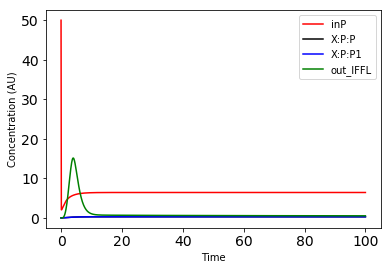

In [6]:
shared_subsystem = cell.setSharedResources()
writeSBML(shared_subsystem.getSBMLDocument(),'models/DP_IFFL_shared.xml')
timepoints = np.linspace(0,100,1000)

# Usage - plotSbmlWithBioscrape(filename, initialTime, timepoints, 
# ListOfSpeciesToPlot, xLabel = 'Time', yLabel = 'Concentration (AU)', xAxisSize = 14, yAxisSize = 14)

plotSbmlWithBioscrape('models/DP_IFFL_shared.xml',0,timepoints,['inP','X:P:P','out_IFFL'])

### Combining multiple SBML models 
The following code snippet implements the second bullet point in the interconnections modeling described above. The `combineSubsystems` method of the Subsystem class is used.
Usage - `self.combineSubsystems(ListOfSubsystems, combineNames = True, mode = 'virtual')`

The Subsystem object which calls the `combineSubsystems` method is a new subsystem object which would contain the combined model.

The second argument is Boolean which is True if all species with same names need to be merged and False otherwise. 

C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\Subsystem.py:843: UserWarning: Removing all duplicates of the reaction inP + X <-> inP:X in the combined model. Check the reaction rate to ensure model is consistent.
  warnings.warn('Removing all duplicates of the reaction {0} in the combined model. Check the reaction rate to ensure model is consistent.'.format(rxn_str))
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\Subsystem.py:843: UserWarning: Removing all duplicates of the reaction inP:X --> inP + X:P in the combined model. Check the reaction rate to ensure model is consistent.
  warnings.warn('Removing all duplicates of the reaction {0} in the combined model. Check the reaction rate to ensure model is consistent.'.format(rxn_str))
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\Subsystem.py:843: UserWarning: Removing all duplicates of the reaction E + X:P <-> E:X:P in the combined model. Check the reaction rate to ensure model is consistent.
  w

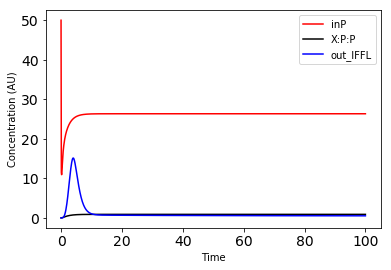

In [10]:
combined_subsystem = createNewSubsystem()
combined_subsystem.combineSubsystems([DP1, DP2, IFFL], 'virtual',True)
writeSBML(combined_subsystem.getSBMLDocument(),'models/DP_IFFL_combined.xml')
plotSbmlWithBioscrape('models/DP_IFFL_combined.xml',0,timepoints,['inP','X:P:P','out_IFFL'])

### Species Identification Interaction Modeling
For the interaction described in (3a) above, the user gives a map of the interaction modeling that is desired. This map uses species names. User specifies how the systems interact by defining the following map
Usage - `interactionMap[speciesA] = speciesB` is a dictionary specifying the map, there may be multiple such entries. 

To model this in a new Subsystem and get a SBML file for it, call the connectInteraction member function of the Subsystem class with the new connected subsystem object which should contain the connected Subsystem model.
Usage - `self.connectSubsystems(ListOfSubsystems, interactionMap, mode = 'virtual', combineAllWithSameNames = True, amount_mode = 'additive', connected_species_amount = 0)`

The resulting Subsystem model in SBML format is stored in the given filename and is simulated using bioscrape. 

C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\Subsystem.py:843: UserWarning: Removing all duplicates of the reaction inP + X <-> inP:X in the combined model. Check the reaction rate to ensure model is consistent.
  warnings.warn('Removing all duplicates of the reaction {0} in the combined model. Check the reaction rate to ensure model is consistent.'.format(rxn_str))
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\Subsystem.py:843: UserWarning: Removing all duplicates of the reaction inP:X --> inP + X:P in the combined model. Check the reaction rate to ensure model is consistent.
  warnings.warn('Removing all duplicates of the reaction {0} in the combined model. Check the reaction rate to ensure model is consistent.'.format(rxn_str))
C:\Users\apand\synBio\txtlsim-python\BioSIMI-Python\modules\Subsystem.py:843: UserWarning: Removing all duplicates of the reaction E + X:P <-> E:X:P in the combined model. Check the reaction rate to ensure model is consistent.
  w

X:P:P


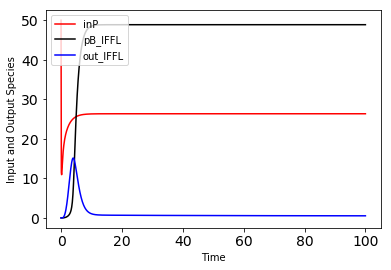

In [12]:
interactionMap = {}
interactionMap['X:P:P'] = 'pA_IFFL'



connected_subsystem = createNewSubsystem(3,1)
connected_subsystem.connectSubsystems([DP1, DP2, IFFL],interactionMap, 'virtual',True)


# (Optional) Write the connected document to SBML file
writeSBML(connected_subsystem.getSBMLDocument(),'models/DP_IFFL_connected.xml')

plotSbmlWithBioscrape('models/DP_IFFL_connected.xml',0,
timepoints,['inP','pB_IFFL','out_IFFL'],'Time',
'Input and Output Species',14,14)

### Other available utility functions
There are other optional steps that you may try or find the need for -

(Optional) Give a new string to suffix all components of the model. 
By default, the names are suffixed by the keyword given to make the Subsystem object.
Usage -  `self.suffixAllElementIds(string)`
Example - `DP1_doc = DP1.suffixAllElementIds('DPx')`


(Optional) Rename IDs of any species/compartments or any other component of the 
subsystem as desired. This may be a helpful utility function to make sure 
that the shared resources (and other interacting elements) have same IDs or names (as desired)
To rename ID of a component and to propagate the changes everywhere in the model, use the following method of the Subsystem class.
Usage - `self.renameSId(old_id, new_id)` (where the ids are string type)
Example - `DP1.renameSId('inp_DP1','inp_DP1_new')`

(Optional) To rename the names of any species, use the following method of the Subsystem class
Usage - `self.renameSName(old_name, new_name)`
Example - `DP1.renameSName('inp', 'input')`
renames all 'inp' named species to 'input'

(Optional) To give a compartment to put the subsystem in, use the following method of the Subsystem class
By default, the subsystem is kept in the "cell" compartment (the System object used)
Usage - `self.setSubsystemCompartments(newCompartments)`
Example -
```
newCompartment = ['cell_new']
DP1.setSubsystemCompartments(newCompartment)
```
(Optional) Write the Subsystem model created to output an SBML file
```
DP1_doc = DP1.getSBMLDocument()
writeSBML(DP1_doc,'models/DP1.xml')
```

(Optional) Set species amounts. 


``DP1.setSpeciesAmounts(species_name_list, amount_list)
``


(Optional) To simulate a Subsystem with bioscrape, without generating plots, returning the data for all species - `simulateBioscrape`


``
DP1.simulateBioscrape(initialTime, timepoints)
``


(Optional) To simulate a variable input of some species and plotting the result using bioscrape simulations - simulateVariableInputsBioscrape

``
DP1.simulateVariableInputBioscrape(ListOfInputs, ListOfListOfAmounts, ListOfSpeciesToPlot, timepoints, mode = 'continue', xlabel = 'Time', ylabel = 'Concentration (AU)', sizeOfXLabels = 14, sizeOfYLabels = 14)
``


(Optional) Plot a Subsystem after simulating with bioscrape


``
DP1.plotBioscrape(ListOfSpeciesToPlot, timepoints, xlabel = 'Time', ylabel = 'Concentration (AU)', sizeOfXLabels = 14, sizeOfYLabels = 14)
``


